<a href="https://colab.research.google.com/github/smayo2/Explore-PhD-Pay/blob/master/phd_stipends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project explores PhD stipends across universities. Dataset can be found in [on the Kaggle website](https://www.kaggle.com/paultimothymooney/phd-stipends/data). The original data is from http://www.phdstipends.com/csv. 

A First Draft...

In [438]:
import pandas as pd
import numpy as np
import io
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

In [439]:
#read data file
file_URL = "https://drive.google.com/file/d/1lp09EJkJJkhKcU_67PSQ27rdunDB4NWK/view?usp=sharing"
data_path = 'https://drive.google.com/uc?export=download&id='+file_URL.split('/')[-2]

df = pd.read_csv(data_path)

Get basic characteristics like size and summary statistics


In [440]:
print(df.head())
display ("Size of Data:", df.shape)
display(df.info())

#not using comments column, so dropping
df.drop(columns = "Comments", inplace=True)

                            University  ...                                           Comments
0  University of Tennessee - Knoxville  ...                                                NaN
1       University of Arizona (U of A)  ...  $10500 per semester. RA/TA required. Need to p...
2       University of Arizona (U of A)  ...                                                NaN
3                University of Florida  ...                                                NaN
4         University of Virginia (UVA)  ...                                                NaN

[5 rows x 11 columns]


'Size of Data:'

(8707, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8707 entries, 0 to 8706
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   University      8444 non-null   object 
 1   Department      8247 non-null   object 
 2   Overall Pay     8686 non-null   object 
 3   LW Ratio        7796 non-null   float64
 4   Academic Year   8703 non-null   object 
 5   Program Year    7687 non-null   object 
 6   12 M Gross Pay  6209 non-null   object 
 7   9 M Gross Pay   2474 non-null   object 
 8   3 M Gross Pay   798 non-null    object 
 9   Fees            3352 non-null   object 
 10  Comments        2155 non-null   object 
dtypes: float64(1), object(10)
memory usage: 748.4+ KB


None

In [441]:
#helper functions

#get total annual pay: by adding summer pay to 9 months pay, where applicable
def calc_total_income(row):
  twelve_mth_pay = row["12 M Gross Pay"]
  if twelve_mth_pay==0:
    return row["9 M Gross Pay"]+ row["3 M Gross Pay"]
  else: return twelve_mth_pay


From the describe method of the dataframe, we see most columns have many missing values. Also most of the data are in string format. We can address these issues as follows.

In [442]:
#replace null values
df['uni_num'] = df.groupby('University')['University'].transform('count')

#consider only universities with 10 or more entries 
df = df[df['uni_num']>=10]

df["University"].fillna("Unspecified", inplace = True)
df["Department"].fillna("Unspecified", inplace = True)

#get list of abbreviated departments
#display(df[(df["Department"].apply(len)<5)]["Department"].value_counts().head(3))
df.dropna(subset=["Overall Pay"], inplace=True)

#convert salaries to numeric 
money_columns = ["Overall Pay", "12 M Gross Pay", "9 M Gross Pay",\
                 "3 M Gross Pay", "Fees"] 

df[money_columns] = df[money_columns].apply(lambda x: x.str.replace(",", "")\
                                            .str.replace("$", "")\
                                            .astype("float")) 



In [443]:

#strip away "st", "nd" etc, assuming that program year is single digit
#if year is NaN replace with zero
df["Program Year"].fillna(0, inplace=True)
df["Program Year"] = df["Program Year"].apply(lambda x: str(x)[0])\
                        .astype("int")

#looking at output we see outliers 
df = df[(np.abs(zscore(df["Overall Pay"])) < 3)]

df["Overall Pay"].fillna(df["Overall Pay"].median(), inplace = True) 

#handle NaNs for academic year:very few, so can drop
df.dropna(subset=["Academic Year"], inplace=True)

#consider numeric columns
numeric_columns = df.select_dtypes('number').columns
#Most NaN are in non-applicable fields, so replacing with zero 
df[numeric_columns] = df[numeric_columns].fillna(0) 

#create a column with total 12 month gross income
df["Total Income"] = df.apply(calc_total_income, axis=1)

#set as categorical
cat_columns = df.select_dtypes('object').columns
df[cat_columns] = df[cat_columns].astype('category')

display(df.info())
#df.head() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7260 entries, 0 to 8706
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   University      7260 non-null   category
 1   Department      7260 non-null   category
 2   Overall Pay     7260 non-null   float64 
 3   LW Ratio        7260 non-null   float64 
 4   Academic Year   7260 non-null   category
 5   Program Year    7260 non-null   int64   
 6   12 M Gross Pay  7260 non-null   float64 
 7   9 M Gross Pay   7260 non-null   float64 
 8   3 M Gross Pay   7260 non-null   float64 
 9   Fees            7260 non-null   float64 
 10  uni_num         7260 non-null   float64 
 11  Total Income    7260 non-null   float64 
dtypes: category(3), float64(8), int64(1)
memory usage: 706.0 KB


None

In [444]:
#get summary statistics for numeric columns
display(df.describe())

,Overall Pay,LW Ratio,Program Year,12 M Gross Pay,9 M Gross Pay,3 M Gross Pay,Fees,uni_num,Total Income
count,7260.000000,7260.000000,7260.000000,7260.000000,7260.000000,7260.000000,7260.000000,7260.000000,7260.000000
mean,25114.598623,1.061382,1.827961,19608.072727,5817.981818,495.453581,806.909504,74.917355,25921.508127
std,8881.622498,0.370956,1.517502,14528.002396,9718.468135,1747.801356,3446.220976,41.137143,8758.078482
min,-23100.000000,-1.050000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000
25%,20000.000000,0.860000,1.000000,0.000000,0.000000,0.000000,0.000000,36.000000,20856.750000
50%,25740.500000,1.110000,1.000000,24776.500000,0.000000,0.000000,0.000000,76.000000,26000.000000
75%,30700.000000,1.300000,3.000000,30206.250000,14679.000000,0.000000,675.000000,106.000000,31000.000000
max,77400.000000,4.120000,6.000000,100000.000000,77400.000000,35000.000000,93725.000000,172.000000,100000.000000


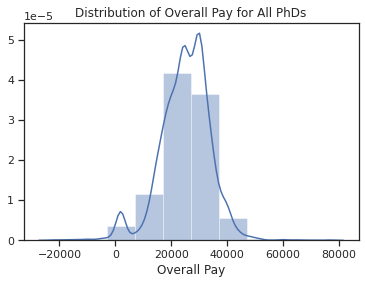

'------------------------------------------'

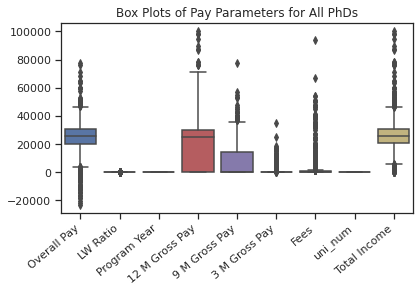

In [445]:
#Visualisations

plot_title = "Distribution of Overall Pay for All PhDs"
ax = sns.distplot(df["Overall Pay"], bins=10)
ax.set_title(plot_title) 
plt.show() 

display("------------------------------------------")
plot_title = "Box Plots of Pay Parameters for All PhDs"
ax=sns.boxplot(data=df) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
ax.set_title(plot_title) 
plt.show()


'------------------------------------------'

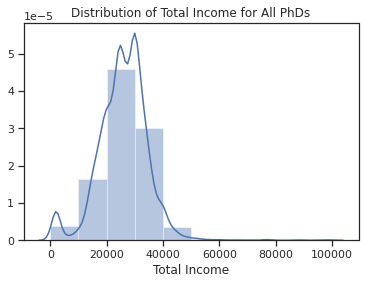

'------------------------------------------'

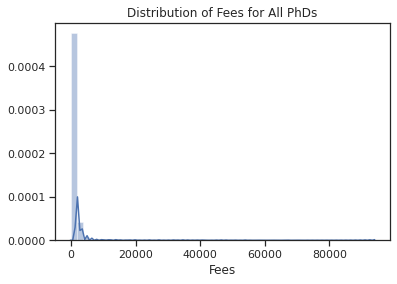

In [446]:

display("------------------------------------------")
plot_title = "Distribution of Total Income for All PhDs"
ax = sns.distplot(df["Total Income"], bins=10)
ax.set_title(plot_title) 
plt.show() 

display("------------------------------------------")
plot_title = "Distribution of Fees for All PhDs"
ax = sns.distplot(df["Fees"])
ax.set_title(plot_title) 
plt.show() 

'top 10 universities for median overall pay'

,min,median,max
University,,,
Stanford University (SU),1460.0,39310.0,68000.0
University of California - San Francisco (UCSF),31375.0,38000.0,42000.0
Mount Sinai School of Medicine,34000.0,37000.0,40000.0
Massachusetts Institute of Technology (MIT),-15000.0,36939.5,60000.0
Harvard University (HU),90.0,35763.0,46000.0
University of Texas Southwestern Medical Center - Dallas,28000.0,34500.0,47487.0
Princeton University,-5000.0,34400.0,60000.0
Columbia University (CU),7500.0,34098.0,51000.0
California Institute of Technology (Caltech),28500.0,34000.0,48000.0


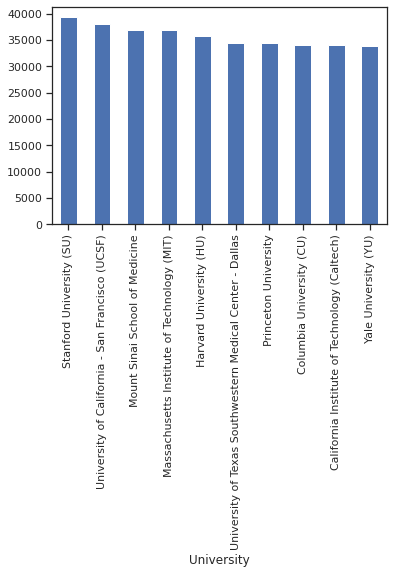

In [447]:

#ignore program year of zero (NaNs)

#top 10 universities for overall pay
display("top 10 universities for median overall pay")
grp_data = df.groupby("University")["Overall Pay"].agg([min, np.median, max])\
        .sort_values(by="median", ascending=False).head(10)
display(grp_data)
grp_data["median"].plot.bar()

' bottom 10 universities for median overall pay'

,min,median,max
University,,,
Texas Tech University (TTU),1152.0,15627.5,29000.0
Oklahoma State University (OSU),900.0,15490.5,28900.0
Washington State University (WSU),12000.0,15015.0,28000.0
University of Texas - El Paso (UTEP),-18500.0,15000.0,24000.0
University of North Carolina - Greensboro (UNCG),1700.0,15000.0,23000.0
University of Oklahoma (OU),1650.0,14900.0,30000.0
New Mexico State University (NMSU),8092.0,14842.0,34000.0
University of Nevada - Las Vegas (UNLV),1700.0,14750.0,18000.0
Ohio University (OU),-1800.0,13600.0,22880.0


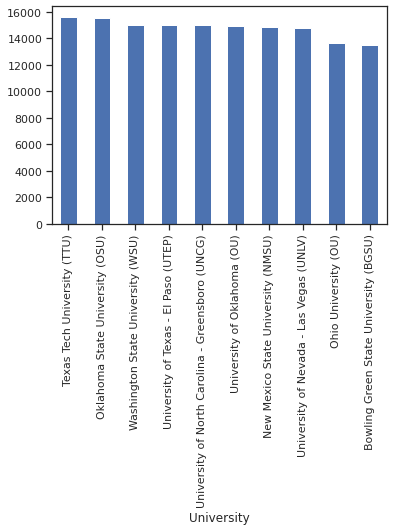

In [448]:
display(" bottom 10 universities for median overall pay")
grp_data = df.groupby("University")["Overall Pay"].agg([min, np.median, max])\
        .sort_values(by="median", ascending=False).tail(10)
display(grp_data)
grp_data["median"].plot.bar()

'top 10 departments for median overall pay'

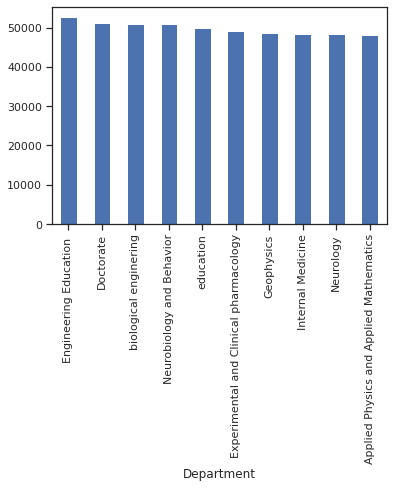

In [449]:

display("top 10 departments for median overall pay")
grp_data = df.groupby("Department")["Overall Pay"].agg([min, np.median, max])\
        .sort_values(by="median", ascending=False).head(10)
grp_data["median"].plot.bar()
plt.show()


'#bottom 10 departments for median overall pay'

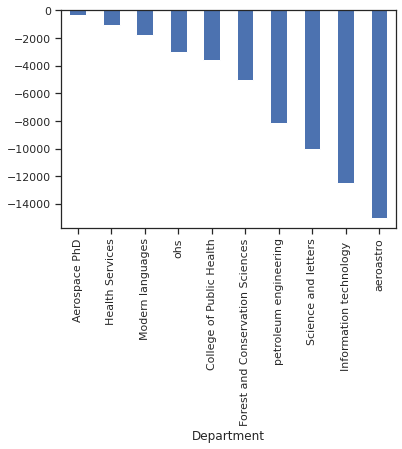

In [450]:

display("#bottom 10 departments for median overall pay")
grp_data = df.groupby("Department")["Overall Pay"].agg([min, np.median, max])\
        .sort_values(by="median", ascending=False).tail(10)
grp_data["median"].plot.bar()
plt.show()

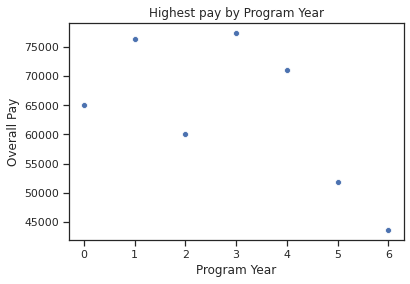

,Program Year,Overall Pay,12 M Gross Pay,9 M Gross Pay,3 M Gross Pay,Fees
0,0,65000.0,78000.0,40000.0,17000.0,50000.0
1,1,76364.0,98269.0,56899.0,25000.0,93725.0
2,2,60000.0,60000.0,37000.0,17000.0,54000.0
3,3,77400.0,100000.0,77400.0,16548.0,40000.0
4,4,71000.0,71000.0,37000.0,35000.0,15000.0
5,5,51900.0,53220.0,37000.0,10000.0,24000.0
6,6,43556.0,43000.0,32868.0,12000.0,36000.0


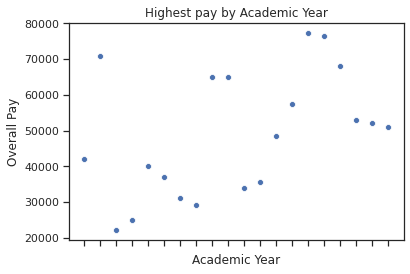

In [451]:

plot_title = "Highest pay by Program Year"
grp_data = df.groupby("Program Year")[money_columns].max().reset_index()
ax = sns.scatterplot(x="Program Year", y="Overall Pay", data=grp_data)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title(plot_title) 
plt.show()
display(grp_data)

plot_title = "Highest pay by Academic Year"
grp_data = df.groupby("Academic Year")[money_columns].max().reset_index()
ax = sns.scatterplot(x="Academic Year", y="Overall Pay", data=grp_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title(plot_title) 
plt.show()

In [452]:
#TODO: some overall pay are negative (mostly because fees exceed pay)
#TODO: clustering

